In [ ]:
# default_exp dataset_ucf101

# Dataset UCF101 Module

> This module focuses on preparing the data of the UCF101 dataset to be used with the core functions.


This notebook uses the [UCF101 – Action Recognition Data Set](https://www.crcv.ucf.edu/data/UCF101.php).

The dataset consists of 13,320 videos between ~2-10 seconds long of humans performing one of 101 possible actions. The dimensions of each frame are 320 by 240.

### Preparing the data

The following function uses a text file provided with the dataset
    which lists all of the relative paths for the videos for the train/test split. 
This function can be called with the location of the dataset 
(e.g. ./data/UCF101/) and returns filenames and classes associated.

This notebook assumes the following data folders:

`{base_directory} 
├── annotations  
├── compressed  
└── UCF-101  `

In [ ]:
#hide
from nbdev.showdoc import *

In [64]:
#export
import numpy as np
import pathlib
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import utils
import torchvision.transforms as transforms
import torch
import cv2

from actions_in_videos.avi import AVI
#from actions_in_videos.data_augmentation import *

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
#export
class UCF101:    
    def __init__(self, base_directory=''):
        """
        Args:
          base_directory: main data folder (e.g. ../data/UCF101)
        """
        self.base_directory = pathlib.Path(base_directory)
    
    def getFileList(self, data_type='train', remove_classname = False, smaller_dataset=False):
        """
        This function uses a text file provided with the dataset
        which lists all of the relative paths for the videos for the train/test split. 

        Args:
          data_type: 'train' | 'test'
          remove_classname: if True does not include the class name in the filenames.
          smaller_dataset: False, uses normal UCF101. True uses a subsampled version (see associated notebook)
        Returns:
          X is a tuple. 
             The first element is a numpy array with the absolute 
               filepaths for the videos for training. 
             The second element is a numpy array of class indices (0-100). 
          class_names is a list of the action categories. 

        """

        base_directory = self.base_directory

        #print(f'[getFileList] Reading data from: {base_directory}')

        # action class labels
        if smaller_dataset:
            class_file = open(base_directory/'annotations/smaller-ucfTrainTestlist/smaller-classInd.txt','r')
        else:
            class_file = open(base_directory/'annotations/ucfTrainTestlist/classInd.txt','r')
        lines = class_file.readlines()
        lines = [line.split(' ')[1].strip() for line in lines]
        class_file.close()
        class_names = np.asarray(lines)

        if data_type == 'train':
            # training data
            if smaller_dataset:
                train_file = open(base_directory/'annotations/smaller-ucfTrainTestlist/smaller-trainlist01.txt','r')
            else:
                train_file = open(base_directory/'annotations/ucfTrainTestlist/trainlist01.txt','r')
            lines = train_file.readlines()      
            if remove_classname:
                filenames = ['/UCF-101/' + line.split(' ')[0].split('/')[1] for line in lines]
            else:
                filenames = ['/UCF-101/' + line.split(' ')[0] for line in lines]
            y_train = [int(line.split(' ')[1].strip())-1 for line in lines]
            y_train = np.asarray(y_train)    
            filenames = [base_directory.as_posix() + filename for filename in filenames]
            train_file.close()
            train = (np.asarray(filenames),y_train)

            X = train
            print('Number of training files:', len(X[0]))

        else:
            # testing data
            if smaller_dataset:
                test_file = open(base_directory/'annotations/smaller-ucfTrainTestlist/smaller-testlist01.txt','r')
            else:
                test_file = open(base_directory/'annotations/ucfTrainTestlist/testlist01.txt','r')
            lines = test_file.readlines()
            filenames = ['/UCF-101/' + line.split(' ')[0].strip() for line in lines]
            classnames = [filename.split('/')[2] for filename in filenames]

            if remove_classname:
                # remove the class name from the filename if needed.
                filenames = ['/UCF-101/' + line.split(' ')[0].split('/')[1].strip() for line in lines]

            y_test = [np.where(classname == class_names)[0][0] for classname in classnames]
            y_test = np.asarray(y_test)
            filenames = [base_directory.as_posix() + filename for filename in filenames]
            test_file.close()
            test = (np.asarray(filenames),y_test)

            X = test
            print('Number of validation files:', len(X[0]))
        #print('[getFileList] Done.')
        return X, class_names


    def downloadData(self):
        """
        Downloads all zip files of the UCF101 dataset.
        """
        
        target_dir = self.base_directory
        print(f'[downloadData] 1/2 Beginning file download to {target_dir}')

        compressed_dir = pathlib.Path(target_dir + '/compressed')
        compressed_dir.mkdir(parents=True, exist_ok=True)

        annotations_dir = pathlib.Path(target_dir + '/annotations')
        annotations_dir.mkdir(parents=True, exist_ok=True)

        destination_dir = pathlib.Path(target_dir + '/UCF-101')
        destination_dir.mkdir(parents=True, exist_ok=True)

        # download annotations for action recognition
        if pathlib.Path(compressed_dir/'UCF101TrainTestSplits-RecognitionTask.zip').exists():
            print ("[downloadData]File UCF101TrainTestSplits-RecognitionTask.zip exists.")
        else:    
            annotation_url = 'https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip'
            filename = wget.download(annotation_url, out=compressed_dir.as_posix(), bar=wget.bar_adaptive)
            print(f'[downloadData]File downloaded to {filename}')

        if pathlib.Path(compressed_dir/'UCF101TrainTestSplits-DetectionTask.zip').exists():
            print ("[downloadData]File UCF101TrainTestSplits-DetectionTask.zip exists.")
        else:        
            # download annotations for action detection
            annotation_url = 'https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-DetectionTask.zip'
            filename =wget.download(annotation_url, out=compressed_dir.as_posix(), bar=wget.bar_adaptive)
            print(f'[downloadData]File downloaded to {filename}')

        # download videos
        if pathlib.Path(compressed_dir/'UCF101.rar').exists():
            print ("[downloadData]File UCF101.rar exists.")
        else:            
            video_url = 'https://www.crcv.ucf.edu/data/UCF101/UCF101.rar'
            filename =wget.download(video_url, out=compressed_dir.as_posix(), bar=wget.bar_adaptive)
            print(f'[downloadData]File downloaded to {filename}')

        print('[downloadData] Done.\n')
        
    def extractData(self):
        """
        Extracts all zip files of the UCF101 dataset.
        It does system calls and it needs unrar (apt-get install unrar-free)        
        """
        
        target_dir = self.base_directory
        print('[extractData] Extracting data...')

        target_dir = pathlib.Path(target_dir)

        compressed_dir = pathlib.Path(target_dir/'compressed')
        compressed_dir.mkdir(parents=True, exist_ok=True)

        annotations_dir = pathlib.Path(target_dir/'annotations')
        annotations_dir.mkdir(parents=True, exist_ok=True)

        destination_dir = pathlib.Path(target_dir/'UCF-101')
        destination_dir.mkdir(parents=True, exist_ok=True)   

        try:
            bash_cmd = 'unrar ' + target_dir.as_posix() + '/UCF101.rar' + ' ' + target_dir.as_posix() + '/UCF-101'
            print(bash_cmd)
            process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
            output, error = process.communicate()
            print(output)
        except Exception as e:
            print(e)
        print()        

        bash_cmd = 'cp ' + target_dir.as_posix() + '/compressed/UCF101TrainTestSplits-RecognitionTask.zip ' + annotations_dir.as_posix() + '/UCF101TrainTestSplits-RecognitionTask.zip'
        print(bash_cmd)
        process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        if len(output) > 0: print(output)
        if len(error) > 0: print(error)
        print()

        bash_cmd = 'unzip ' + annotations_dir.as_posix() + '/UCF101TrainTestSplits-RecognitionTask.zip -d ' + annotations_dir.as_posix()
        print(bash_cmd)
        process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        if len(output) > 0: print(output)
        if len(error) > 0: print(error)
        print()    

        bash_cmd = 'cp ' + target_dir.as_posix() + '/compressed/UCF101TrainTestSplits-DetectionTask.zip ' + annotations_dir.as_posix() + '/UCF101TrainTestSplits-DetectionTask.zip'
        print(bash_cmd)
        process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        if len(output) > 0: print(output)
        if len(error) > 0: print(error)
        print()

        bash_cmd = 'unzip ' + annotations_dir.as_posix() + '/UCF101TrainTestSplits-DetectionTask.zip -d ' + annotations_dir.as_posix()
        print(bash_cmd)    
        process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        if len(output) > 0: print(output)
        if len(error) > 0: print(error)
        print()

        bash_cmd = 'rm ' + target_dir.as_posix() + '/annotations/*.zip'
        print(bash_cmd)    
        process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        if len(output) > 0: print(output)
        if len(error) > 0: print(error)

        print()
        print('[extractData] Done.')

Quickly verifies that the class does what we need:

In [11]:
ucf = UCF101('../data/UCF101/')

In [12]:
X, class_names = ucf.getFileList(data_type='train', smaller_dataset=True)

file_list, labels = X[0], X[1]

Number of training files: 282


In [13]:
file_list[0], labels[0], class_names[0]

('../data/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi',
 0,
 'ApplyEyeMakeup')

## Datasets

### Single Frame

The SingleFrameDataset class gets a single random frame from an AVI video.
The video is identified through an idx that corresponds to the index in a file list.

In [ ]:
#export
class SingleFrameDataset(Dataset):
    """Single frame dataset for the UCF101."""

    def __init__(self, dataset_path, training=True, img_type=np.float32, transform=None, verbose=False, smaller_dataset=False):
        """
        Args:            
            file_list: list of files as a numpy array.
            labels: one entry per filename in the list of files as a numpy array.
            train: flag to say whether train or test dataset is used.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.verbose = verbose
        self.training = True
        ucf = UCF101(dataset_path)
        
        X, class_names = ucf.getFileList(data_type='train' if training else 'test', smaller_dataset=smaller_dataset)
        self.file_list, self.labels = X[0], X[1]
        self.class_names = class_names
        self.num_classes = len(self.class_names)
        self.img_type = img_type
        self.transform = transform
        
    def setVerbose(self, flag=False):
        self.verbose=flag
        
    def getClassName(self, idx):
        return self.class_names[idx]
    
    def getFileName(self, idx):
        return self.file_list[idx]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        video_list = self.file_list[idx]
        #video_list = self.file_list[idx % len(self)] # wraps up if an out of index idx is used.
        avi = AVI(video_list, verbose=self.verbose, img_type=self.img_type)
                
        frame = avi.getRandomFrame()
                                    
        label = self.labels[idx]
        label = np.array([label])

        if self.transform:
#            frame = frame.transpose(2,0,1)
            frame = self.transform(frame)         
            
        return frame, label
            

We can now test it to verify what this does.

We can now create our dataset:

In [ ]:
train_ds = SingleFrameDataset(dataset_path='../data/UCF101/', training=True, transform=None)

In [ ]:
print(train_ds.num_classes)

Note that in this case, the shape is the one of a PIL image. No transformation is applied

In [ ]:
train_ds[0][0].shape

And plot one of the frames. Note that each frame is extracted at random so multiple run of the cell below will show different results.

Even though it is not strictly necessary, we will make use of the AVI class to display the frame.

In [ ]:
idx = 1000
AVI.frameShow(train_ds[idx][0], title=train_ds.getClassName(train_ds[idx][1]))

### DataLoader

In this case, we do not need to define a specialise DataLoader class and we can use the pytorch version.

`torch.utils.data.DataLoader` is an iterator which provides:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

this avoid losing a lot of features by using a simple for loop to iterate over the data.


One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using `collate_fn`. However, default collate should work fine for most use cases.

In [ ]:
#hide
# def singleFrameReplicate_collate(batch):
#     len_batch = len(batch) # original batch length
#     batch = list(filter (lambda x:x is not None, batch)) # filter out all the Nones
#     if len_batch > len(batch): 
#         # if there are samples missing just use existing members, doesn't work if you reject every sample in a batch
#         diff = len_batch - len(batch)
#         for i in range(diff):
#             batch = batch + batch[:diff]
#     return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
#hide
# def singleFrame_collate(batch):
#     len_batch = len(batch) # original batch length
#     batch = list(filter (lambda x:x is not None, batch)) # filter out all the Nones
#     if len_batch > len(batch): 
#          print('FILTER!')
#         # source all the required samples from the original dataset at random
#         diff = len_batch - len(batch)
#         for i in range(diff):
#             batch.append(dataset[np.random.randint(0, len(dataset))])

#     return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
train_dl = DataLoader(dataset=train_ds, batch_size=4, shuffle=True, num_workers=4) # collate_fn=singleFrame_collate,

To understand what the DataLoader class does, let's define a ShowBath class.

In [ ]:
#export
class BatchShower:        
    def __init__(self, dl):
        self.dl = dl
    
    def showBatch(self, idx, scale=1):
        """Loops through the dataloader and shows only one batch (idx)"""
        assert idx >= 0 and idx <= np.floor(len(self.dl.dataset)/self.dl.batch_size), "selected batch index out of batch size range: [0, %d]" % np.floor(len(self.dl.dataset)/self.dl.batch_size)
        
        for i_batch, sample_batched in enumerate(self.dl):   
#            print(i_batch, sample_batched[0].size())
#             observe the idx-th batch and stop
            if i_batch == idx:
                print(f'batch sample size: {sample_batched[0].shape}')
            
                plt.figure(figsize=(10,10))
                image, label = sample_batched[0], sample_batched[1]
                class_name = self.dl.dataset.getClassName(sample_batched[1])
                self.showThisBatch(image, label, scale)
                print(class_name.tolist())
                plt.axis('off')
                plt.ioff()
                plt.show()
                break     
        
        
    def showThisBatch(self, images_batch, labels_batch, scale=1):
        """Show image for a batch of samples. 
        Must be tensors of size (bs x w x h x channels).        
        """
        batch_size = len(images_batch)
        im_size = images_batch.size()

        ncols = int(np.ceil(np.sqrt(batch_size)))        
        for i in range(batch_size):
            ax = plt.subplot(ncols, ncols, i+1)
            if type(images_batch[i]) == torch.Tensor:
                frame = images_batch[i].data.numpy()
                frame = frame/255.

            if frame.shape[0] <= 3:
                frame = frame.transpose(1, 2, 0)                
            frame_v_mean = np.mean(frame)                        
            frame = scale*frame            
            frame[frame<0] = 0
            if np.mean(frame) < 2:                
                frame[frame>1] = 1
            else:
                frame[frame>255] = 255            
                
            plt.imshow(frame)   
#           plt.tight_layout()
            ax.axis('off')                            


In [ ]:
sb = BatchShower(train_dl)
sb.showBatch(idx=3)

And if we want to add more complex transformation:

In [ ]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define training set
train_ds = SingleFrameDataset(
    dataset_path='../data/UCF101/',
    training=True,
    img_type=np.uint8,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean, std), 
    ])
)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

In [ ]:
sb = BatchShower(train_dl)
sb.showBatch(3, 255) 

Using my custom transformations:

In [ ]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define training set
train_ds = SingleFrameDataset(
    dataset_path='../data/UCF101/',
    training=True,
    img_type=np.float32,
    transform=transforms.Compose(
    [
        ImageRescale((224,224)),
        ImageToTensor(),
        ImageNormalize(mean, std), 
    ])
)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

In [ ]:
sb = BatchShower(train_dl)
sb.showBatch(3, 255) 

### Sequence Dataset

In [ ]:
#export
class SequenceDataset(Dataset):
    """Sequence based dataset for the UCF101.
    
    Output is of shape:
        seq_len, H, W, C
        
    Note that when this is passed onto a DataLoader with toTensor() transform, it changes its shape to:
        batch_size, seq_length, C, H, W 
        
    """

    def __init__(self, dataset_path, sequence_length, sample_interval=1, training=True, transform=None, safe=True, verbose=False, smaller_dataset=False):
        """
        Args:            
            file_list: list of files as a numpy array.
            labels: one entry per filename in the list of files as a numpy array.
            train: flag to say whether train or test dataset is used.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sequence_length = sequence_length
        self.sample_interval = sample_interval
        self.training = training
        self.safe = safe # impacts the getSequence method of the AVI class accessed through getRandomSequence method.
        self.verbose = verbose

        ucf = UCF101(dataset_path)
        
        X, class_names = ucf.getFileList(data_type='train' if training else 'test', smaller_dataset=smaller_dataset)
        self.file_list, self.labels = X[0], X[1]
        self.class_names = class_names
        self.num_classes = len(self.class_names)
        self.transform = transform
        self._debug = False
        self.lastfile_loaded = None
    
    def setVerbose(self, flag=False):
        self.verbose=flag
    
    def debug(self, flag=False, seq_idx=0, seq_len=6):
        self._debug = flag
        self._debug_seq_idx = seq_idx
        self._debug_seq_len = seq_len
        
    def getClassName(self, idx):
        return self.class_names[idx]
    
    def getFileName(self, idx):
        return self.file_list[idx]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        """
        Args:
        - idx: item index
        returns: 
        - sequence: list of frames of length self.sequence_length
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #video_list = self.file_list[idx]
        video_list = self.file_list[idx % len(self)] # wraps up if an out of index idx is used.
        avi = AVI(video_list, verbose=self.verbose, safe=self.safe)  # setting verbose to True might help debugging.
    
        # saves last files open
        
        # frames is a numpy matrix of shape seq_len, H, W, C
        if self._debug:
            # WARNING: THIS IS ONLY FOR DEBUGGING PURPOSES. SHOULD BE REMOVED LATER.
            # print(f'video_list: {video_list}')
            # self.lastfile_loaded = video_list
            #         print("avi._attributes['n-frames']-idx_0:", avi._attributes['n-frames']-idx_0)
            #idx_0 = avi._attributes['n-frames']-2
#             frames = avi.getSequence(idx_0=idx_0, seq_len=avi._attributes['n-frames']-idx_0, sample_interval=1, circular=False)  
            idx_0 = self._debug_seq_idx
            frames = avi.getSequence(idx_0=idx_0, seq_len=self._debug_seq_len, sample_interval=1, circular=False)  
        else:
            frames = avi.getRandomSequence(self.sequence_length, self.sample_interval)
                             
        #print(len(frames))
        label = self.labels[idx]
        label = np.array([label])
                
        # Extract frames as tensors
        image_sequence = []
        
        #image_sequence = torch.stack(image_sequence)        
        #     frame = frame.transpose(2,0,1)
        
        if self.transform:
            sequence = None 
            for i, frame in enumerate(frames):             
                frame = self.transform(frame)  # here frame might be a tensor
                if sequence is None:           
                    # we still need to allocate it.
                    sequence = np.zeros(np.array(np.append(np.array([self.sequence_length]), np.array(frame.shape))))
                sequence[i,:,:,:] = frame
            frames = sequence
#         frame = np.asarray(frame)
#         frame = frame.transpose(3,0,1,2)
#         if type(frame) == torch.Tensor:
#             sequence = torch.stack(sequence)
        
        return frames, label
            

In [ ]:
mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)


trfms=transforms.Compose(
[
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std), 
])

train_ds = SequenceDataset(dataset_path='../data/UCF101/', 
                           sequence_length=16, 
                           training=True, 
                           transform=trfms, 
                           verbose=True, 
                           smaller_dataset=False)

print(f"Num of classes: {train_ds.num_classes}")

And plot one of the possible random sequences. Note that each sequence is extracted at random so multiple run of the cell below will show different results.

Even though it is not strictly necessary, we will make use of the AVI class to display the frame.

In [ ]:
idx = np.where(train_ds.file_list == '../data/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi')[0][0]
#idx = np.where(train_ds.file_list == '../data/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi')[0][0]
print(idx, train_ds.getFileName(idx))

In [ ]:
fig = plt.figure(figsize=(20,20))
sequence, label = train_ds[idx]
print(train_ds.lastfile_loaded)
AVI.sequenceShow(sequence.transpose(0,2,3,1), label)

Before doing so, we verify that the SequenceDataset is robust against frame errors in a sequence. This is a hack at the moment but it seems to be doing the job for now..

We now look for one specific file that we know is trouble:

In [ ]:
idx = np.where(train_ds.file_list == '../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi')[0][0]
print(idx, train_ds.getFileName(idx))

The following cell is only to see what attributes the file has:

In [ ]:
avi = AVI(train_ds.file_list[idx], verbose=True)
print(avi._attributes)

In [ ]:
train_ds.debug(True, avi._attributes['n-frames']-2, avi._attributes['n-frames']-idx_0) # When we do this, we force specific frames to be used.

In [ ]:
fig = plt.figure(figsize=(20,20))
sequence, label = train_ds[idx]
print(train_ds.lastfile_loaded)
AVI.sequenceShow(sequence.transpose(0,2,3,1), label)

Turn off debugging and go back to usual behaviour.
We can still use the same file (id 2496) as it is quite unlikely that we end up having a corrupted first frame.

In [ ]:
train_ds.debug(False)

In [ ]:
sequence, label = train_ds[2496]
AVI.sequenceShow(sequence.transpose(0,2,3,1), label, max_seq=4)
print(train_ds.lastfile_loaded)

Let's see if we need a collate_fn for sequences:

In [ ]:
def sequence_collate(batch):
    len_batch = len(batch) # original batch length
    batch = list(filter (lambda x:x is not None, batch)) # filter out all the Nones
    
    if len_batch > len(batch): 
        print('dataset_ucf101:sequence_collate. FILTER!')
        # source all the required samples from the original dataset at random
        diff = len_batch - len(batch)
        for i in range(diff):
            batch.append(dataset[np.random.randint(0, len(dataset))])

    return torch.utils.data.dataloader.default_collate(batch)

Let's create set the verbose flag to False now:

In [ ]:
train_ds.setVerbose(False)

In [ ]:
train_dl = DataLoader(dataset=train_ds, batch_size=4, collate_fn=singleFrame_collate, shuffle=True, num_workers=4)

Remove the collate function:

In [ ]:
train_ds = SequenceDataset(dataset_path='../data/UCF101/', 
                           sequence_length=16, 
                           training=True, 
                           transform=None, 
                           verbose=True, 
                           smaller_dataset=False)

print(f"Num of classes: {train_ds.num_classes}")

In [ ]:
train_dl = DataLoader(dataset=train_ds, batch_size=2, shuffle=False, num_workers=0)

To understand that a Dataloader for a SequenceDataset does, let's define a SequenceBatchShower:

In [18]:
#export
class SequenceBatchShower:        
    def __init__(self, dl, fig_size=5, max_batch_len=4, max_seq_len=4):
        self.dl = dl
        self.fig_size = fig_size
        self.max_batch_len = max_batch_len # max number of batch element to show
        self.max_seq_len = max_seq_len # max element in each sequence to show
        
    def __repr__(self):
        return f'batch-size: {self.dl.batch_size} fig-size:{self.fig_size}, max_batch_len: {self.max_batch_len}, max_seq_len: {self.max_seq_len}'
    
    def showBatch(self, idx, scale=1, permuteToImg=None):
        """Loops through the dataloader and shows only one batch (idx).
        Args:
        - idx: batch number to show
        - scale: accounts for different normalisation constants
        - permuteToImg: let you change the axis of your image to be shown using imshow."""
        assert idx >= 0 and idx <= np.floor(len(self.dl.dataset)/self.dl.batch_size), "selected batch index out of batch size range: [0, %d]" % np.floor(len(self.dl.dataset)/self.dl.batch_size)
        
        for i_batch, sample_batched in enumerate(self.dl):   
            # print(i_batch, sample_batched[0].shape)
            # observe the idx-th batch and stop
            if i_batch == idx:
                print(f'batch sample size: {sample_batched[0].shape}')
                
                plt.figure(figsize=(10,10))
                sequence, label = sample_batched[0], sample_batched[1]
                
                #print(torch.min(sequence), torch.max(sequence))
                
                class_name = self.dl.dataset.getClassName(sample_batched[1])
                #print(f'filename: {self.dl.dataset.getFileName(sample_batched[1])}')
                self.showThisBatch(sequence, label, scale, permuteToImg)
                if self.dl.batch_size == 1:
                    print(class_name.tolist())
                else:
                    print(class_name.tolist()[:self.max_batch_len])
                
                #print(f'self.dl.dataset.lastfile_loaded: {self.dl.dataset.lastfile_loaded}')
                
                plt.axis('off')
                plt.ioff()
                plt.show()
                break     
        
        
    def showThisBatch(self, sequence_batch, labels_batch, scale=1, permuteToImg=None):
        """Show a sequence of images for a batch of samples. 
        Must be tensors of size (bs x seq_len x w x h x channels).        
        """
        batch_size = len(sequence_batch)
        ncols = int(np.ceil(np.sqrt(batch_size)))  
        for i in range(int(np.min([batch_size, self.max_batch_len]))):
            fig = plt.figure(figsize=(self.fig_size,self.fig_size)); # ax = plt.subplot(ncols, ncols, i+1)
            if permuteToImg is not None and len(permuteToImg)>0:
                one_sequence = sequence_batch[i].permute(permuteToImg).numpy()
            else:
                one_sequence = sequence_batch[i].numpy() # I need seq_len x H x W x C here (e.g. .permute(0,2,3,1) corresponds to .transpose())                        
            AVI.sequenceShow(one_sequence, max_seq=self.max_seq_len) 
            for a in fig.axes:
                a.axis('off')  


In [19]:
sb = SequenceBatchShower(train_dl, max_batch_len=4, max_seq_len=16)

In [ ]:
fig = plt.figure(figsize=(20,20))
sb.showBatch(idx=0, scale=255, permuteToImg=None)

In [ ]:
sb = SequenceBatchShower(train_dl, max_batch_len=2, max_seq_len=6)
print(sb)
sb.showBatch(idx=4, scale=255, permuteToImg=None)

And now with transformations:

In [ ]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define training set
train_ds = SequenceDataset(
    dataset_path='../data/UCF101/',
    sequence_length=6,
    training=True,
    transform=transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean, std), 
    ])
)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

In [ ]:
sb = SequenceBatchShower(train_dl)
sb.showBatch(idx=3, scale=255, permuteToImg=(0,2,3,1)) 

With more complex transformations. I am going to use the test set (training=False) and set suffle to False in the dataloader.

In [ ]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# ImageRandomCrop(out_ratio=0.7, p_crop=0.5),
# ImageRandomHorizontalFlip(p_flip=0.5),
# ImageRescale((opt['img-size'], opt['img-size'])),
# ImageAddRandomBrightness(),                               
# ImageNormalize(),
# ImageToTensor()

# Define training set
train_ds2 = SequenceDataset(
    dataset_path='../data/UCF101/',
    sequence_length=6,
    training=False,
    transform=transforms.Compose(
    [
        ImageRandomCrop(out_ratio=0.7, p_crop=1),
        ImageRandomHorizontalFlip(p_flip=1),        
        ImageRescale((224, 224)),  
        ImageAddRandomBrightness(),                                       
        ImageToTensor(),
        ImageNormalize(mean, std), 
    ])
)
train_dl = DataLoader(train_ds2, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
sb = SequenceBatchShower(train_dl, max_seq_len=6)
sb.showBatch(idx=3, scale=255, permuteToImg=(0,2,3,1)) 

In [75]:
#export
class ARSequenceDataset(Dataset):
    """Sequence based dataset for the UCF101.
    
    Output is of shape:
        seq_len, H, W, C
        
    Note that when this is passed onto a DataLoader with toTensor() transform, it changes its shape to:
        batch_size, seq_length, C, H, W 
        
    """

    def __init__(self, dataset_path, sequence_length, sample_interval=1, training=True, transform=None, safe=True, verbose=False, smaller_dataset=False):
        """
        Args:            
            file_list: list of files as a numpy array.
            labels: one entry per filename in the list of files as a numpy array.
            train: flag to say whether train or test dataset is used.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sequence_length = sequence_length
        self.sample_interval = sample_interval
        self.training = training
        self.safe = safe # impacts the getSequence method of the AVI class accessed through getRandomSequence method.
        self.verbose = verbose

        ucf = UCF101(dataset_path)
        
        X, class_names = ucf.getFileList(data_type='train' if training else 'test', smaller_dataset=smaller_dataset)
        self.file_list, self.labels = X[0], X[1]
        self.class_names = class_names
        self.num_classes = len(self.class_names)
        self.transform = transform
        self._debug = False
        self.lastfile_loaded = None
    
    def setVerbose(self, flag=False):
        self.verbose=flag
    
    def debug(self, flag=False, seq_idx=0, seq_len=6):
        self._debug = flag
        self._debug_seq_idx = seq_idx
        self._debug_seq_len = seq_len
        
    def getClassName(self, idx):
        return self.class_names[idx]
    
    def getFileName(self, idx):
        return self.file_list[idx]

    def __len__(self):
        return len(self.file_list)

    def loadSequence(self, args):
        mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
        std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)

        curr_w = 320
        curr_h = 240
        height = width = 224
        num_of_frames=16

        (filename,augment) = args    

        data = np.zeros((3,num_of_frames,height,width),dtype=np.float32)
        try:
            ### load file from AVI
            cap = cv2.VideoCapture(filename)   
            if not cap.isOpened(): 
                print(f"could not open {filename}") 
                return
            nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            #frameWidth   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            #frameHeight  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps     = cap.get(cv2.CAP_PROP_FPS)

            frame_index = np.random.randint(nFrames - num_of_frames)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            
            #print(f'Frame-index-0: {frame_index}')
            video = []        
            f_count = 0
            while cap.isOpened() and f_count < num_of_frames:
                frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
                ret, frame = cap.read() 
                video.append(frame)
                f_count += 1

            cap.release()

            if(augment==True):
                ## RANDOM CROP - crop 70-100% of original size
                ## don't maintain aspect ratio
                resize_factor_w = 0.3*np.random.rand()+0.7
                resize_factor_h = 0.3*np.random.rand()+0.7
                w1 = int(curr_w*resize_factor_w)
                h1 = int(curr_h*resize_factor_h)
                w = np.random.randint(curr_w-w1)
                h = np.random.randint(curr_h-h1)
                random_crop = np.random.randint(2)

                ## Random Flip
                random_flip = np.random.randint(2)

                ## Brightness +/- 15
                brightness = 30
                random_add = np.random.randint(brightness+1) - brightness/2.0

                data = []
                for frame in video:
                    if(random_crop):
                        frame = frame[h:(h+h1),w:(w+w1),:]
                    if(random_flip):
                        frame = cv2.flip(frame,1)
                    frame = cv2.resize(frame,(width,height))
                    frame = frame.astype(np.float32)

                    frame += random_add
                    frame[frame>255] = 255.0
                    frame[frame<0] = 0.0

                    frame = frame/255.0
                    frame = (frame - mean)/std
                    data.append(frame)
                data = np.asarray(data)

            else:
                # don't augment
                data = []
                for frame in video:
                    frame = cv2.resize(frame,(width,height))
                    frame = frame.astype(np.float32)
                    frame = frame/255.0
                    frame = (frame - mean)/std
                    data.append(frame)
                data = np.asarray(data)

            data = data.transpose(3,0,1,2)
        except:
            print("Exception: " + filename)
            data = np.array([])
        return data
    
    
    def __getitem__(self, idx):
        """
        Args:
        - idx: item index
        returns: 
        - sequence: list of frames of length self.sequence_length
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        video_list = self.file_list[idx]
        #video_list = self.file_list[idx % len(self)] # wraps up if an out of index idx is used.
        arg = (video_list, self.training)
        frames = self.loadSequence(arg)
        label = self.labels[idx]
        label = np.array([label])                        
        return frames, label
            

In [76]:
train_ds = ARSequenceDataset(dataset_path='../data/UCF101/', 
                           sequence_length=16, 
                           training=True, 
                           transform=None, 
                           verbose=True, 
                           smaller_dataset=False)

print(f"Num of classes: {train_ds.num_classes}")

train_dl = DataLoader(dataset=train_ds, batch_size=2, shuffle=False, num_workers=0)

Number of training files: 9537
Num of classes: 101


In [77]:
!ls ../data/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi

../data/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi


batch sample size: torch.Size([2, 3, 16, 224, 224])
[['ApplyEyeMakeup'], ['ApplyEyeMakeup']]


<Figure size 720x720 with 0 Axes>

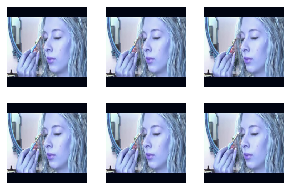

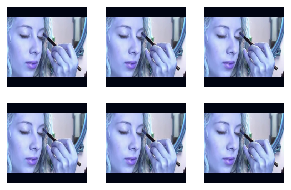

In [78]:
sb = SequenceBatchShower(train_dl, max_seq_len=6)
sb.showBatch(idx=3, scale=0, permuteToImg=(1,2,3,0)) 

## fin.

In [79]:
#hide
from nbdev.export import *
notebook2script()

Converted 01_dataset_ucf101.ipynb.
Converted 02_avi.ipynb.
Converted 04_data_augmentation.ipynb.
Converted 05_models.ipynb.
Converted 06_models-resnet_3d.ipynb.
Converted 07_utils.ipynb.
Converted 10_run-baseline.ipynb.
Converted 11_run-sequence-convlstm.ipynb.
Converted 12_run-sequence-3d.ipynb.
Converted Smaller UCF-dataset-Copy1.ipynb.
Converted Smaller UCF-dataset.ipynb.
Converted index.ipynb.


# 